Files needed:

1. LFW Face Database - http://vis-www.cs.umass.edu/lfw/lfw.tgz
2. Stanford Dogs Dataset - http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import tarfile
import random

In [0]:
# extract files from .tar
def extract_tar(init_dir, exc_dir):
    tf = tarfile.open(init_dir)
    tf.extractall(exc_dir)
    tf.close()

In [0]:
# load images from data_dir
def load_dataset(data_dir):
    dataset = []
    for filename in glob.glob(data_dir):
        img = plt.imread(filename)
        dataset.append(img)
    return dataset

In [0]:
# plot images
def imshow(img, title=None, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [0]:
# transform original photos
# into black and white ones scaled to [0,1], to desired shape and flatten
def images_transform(images, shape):
    transformed = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255
        gray = cv2.resize(gray, shape).reshape(-1)
        transformed.append(gray)
    return np.asarray(transformed)

In [0]:
# split data into train and test set
def split_data(data, labels, ratio=0.7):
    n = data.shape[0]
    ids = np.arange(n)
    random.shuffle(ids)
    X = data[ids]
    y = labels[ids]
    stop = int(ratio*n)
    X_train = X[:stop]
    y_train = y[:stop]
    X_test = X[stop:]
    y_test = y[stop:]
    return X_train, y_train, X_test, y_test

In [0]:
# initialize W and b
def init_params(n_layers, n_neurons):
    params = {}
    for i in range(n_layers):
        params["W" + str(i+1)] = 0.1 * np.random.randn(n_neurons[i], n_neurons[i+1])
        params["b" + str(i+1)] = np.zeros((1, n_neurons[i+1]))
        
    return params

In [0]:
# make mini batches
def mini_batches(X, y, batch_size=64):
    batches = []
    n = int(X.shape[0] / batch_size)
    ids = np.arange(X.shape[0])
    random.shuffle(ids)
    X_temp = X[ids]
    y_temp = y[ids]
    
    for i in range(n):
        batches.append((X_temp[i*batch_size : (i+1)*batch_size], y_temp[i*batch_size : (i+1)*batch_size]))
        
    return batches

In [0]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

In [0]:
def ReLU(z):
    z[z < 0] = 0
    return z

In [0]:
# derivative of ReLU
def dReLU(z):
    dRelu = 1*(z > 0)
    return dRelu

In [0]:
# forward propagation
def forward(X, params):
    forwards = {}
    A = X
    forwards["A0"] = A
    for i in range(int(len(params) / 2)):
        Z = np.dot(A, params["W" + str(i+1)]) + params["b" + str(i+1)]
        A = sigmoid(Z)
        forwards["Z" + str(i+1)] = Z
        forwards["A" + str(i+1)] = A
    return forwards

In [0]:
# backward propagation
def backward(X, y, params, forwards, l_rate, eps=1e-6):
    y = y.reshape(-1,1)
    n_layers = int(len(params) / 2)
    m = len(y)
    
    # pochodne dla warstwy wyjściowej z funkcją aktywacji Sigmoid
    dLdA = - y / (forwards["A" + str(n_layers)] + eps) + (1 - y) / (1 - forwards["A" + str(n_layers)] + eps)
    dLdZ = dLdA * forwards["A" + str(n_layers)] * (1 - forwards["A" + str(n_layers)])
    dLdW = np.dot(forwards["A" + str(n_layers-1)].T, dLdZ) / m
    dLdb = np.sum(dLdZ, axis=0, keepdims=True) / m
    params["W" + str(n_layers)] = params["W" + str(n_layers)] - l_rate * dLdW
    params["b" + str(n_layers)] = params["b" + str(n_layers)] - l_rate * dLdb 
    
    # pochodne dla warstw ukrytych z funkcją aktywacji ReLU
    for i in np.arange(n_layers-1, 0, -1):
        dLdA = np.dot(dLdZ, params["W" + str(i+1)].T)
        dLdZ = dLdA * dReLU(forwards["A" + str(i)])
        dLdW = np.dot(forwards["A" + str(i-1)].T, dLdZ) / m 
        dLdb = np.sum(dLdZ, axis=0, keepdims=True) / m
        params["W" + str(i)] = params["W" + str(i)] - l_rate * dLdW
        params["b" + str(i)] = params["b" + str(i)] - l_rate * dLdb
    return params

In [0]:
# loss function
def cross_entropy(probs, y, eps=1e-6):
    y = y.reshape(-1, 1)
    costs = y * np.log(probs + eps) + (1 - y) * np.log(1 - probs + eps)
    return -np.sum(costs)

# Model
## Data preprocessing

In [0]:
extract_tar(r'datasets\lfw.tgz', r'datasets\faces')
extract_tar(r'datasets\dogs.tar', r'datasets\dogs')

In [0]:
faces = load_dataset(r'datasets\faces\lfw\C*\*.jpg')
dogs = load_dataset(r'datasets\dogs\Images\*2086*\*.jpg')

# original images
images = np.asarray(faces + dogs)
# transformed images
data = images_transform(images, (100,100))

labels = np.append(np.ones(len(faces)), np.zeros(len(dogs)))

In [0]:
X_train, y_train, X_test, y_test = split_data(data, labels)

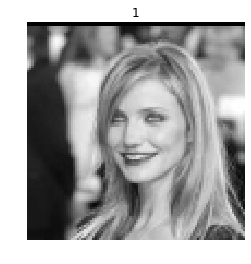

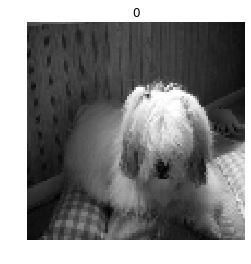

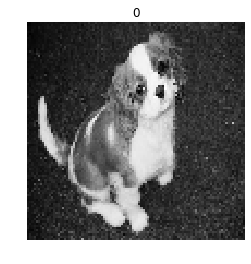

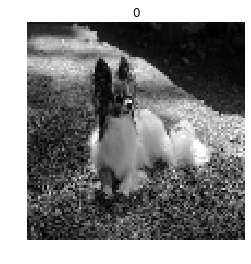

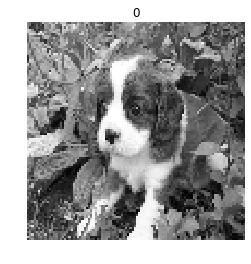

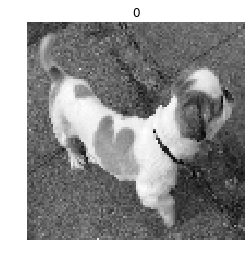

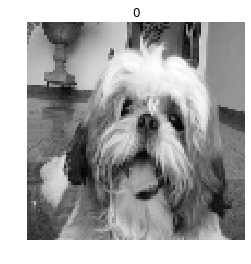

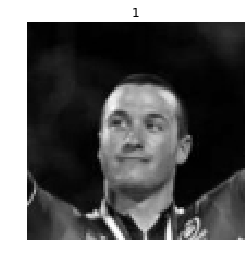

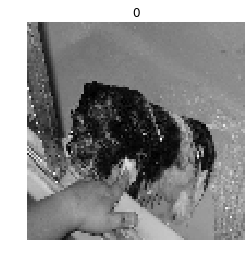

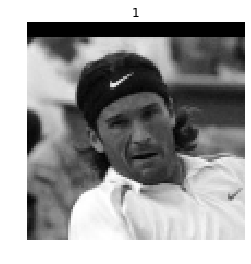

In [0]:
for i in range(10):
    # transformed images
    imshow(X_train[i].reshape(100,100), int(y_train[i]), cmap='gray')
    
    # original images - faces
    #imshow(images[i], int(labels[i]))
    
    # original imahes - dogs
    #imshow(images[-i-1], int(labels[-i-1]))

## Model training

In [0]:
n_epochs = 10000
l_rate = 1e-3
n_batches = int(X_train.shape[0] / 64)

n_layers = 3
n_neurons = [X_train.shape[1], 128, 128, 1]

params = init_params(n_layers, n_neurons)

In [0]:
for i in range(n_epochs):
    batches = mini_batches(X_train, y_train)
    loss_ac = []
    for (X_batch, y_batch) in batches:
        # forward propagation
        forwards = forward(X_batch, params)
        loss_ac.append(cross_entropy(forwards["A" + str(n_layers)], y_batch))
        # backward propagation
        params = backward(X_batch, y_batch, params, forwards, l_rate)
    
    # accuracy on the train and test sets
    if i%1 == 0:
        train_preds = 1 * (forward(X_train, params)["A" + str(n_layers)] >= 0.5)
        train_accuracy = np.sum(train_preds == y_train.reshape(-1,1)) / y_train.shape[0] * 100
        
        test_preds = 1 * (forward(X_test, params)["A" + str(n_layers)] >= 0.5)
        test_accuracy = np.sum(test_preds == y_test.reshape(-1,1)) / y_test.shape[0] * 100
        
        print('Epoch: {} Loss: {:.4f} Train accuracy {:.2f}% Test accuracy: {:.2f}%'.format(i+1, np.mean(loss_ac), train_accuracy, test_accuracy))
        
    if i%100 == 0:
        l_rate /= 2

Epoch: 1 Loss: 46.5141 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 2 Loss: 45.0027 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 3 Loss: 44.4096 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 4 Loss: 43.9956 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 5 Loss: 43.7362 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 6 Loss: 43.5311 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 7 Loss: 43.3668 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 8 Loss: 43.2411 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 9 Loss: 43.1760 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 10 Loss: 43.0996 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 11 Loss: 43.0590 Train accuracy 54.77% Test accuracy: 54.55%
Epoch: 12 Loss: 43.0026 Train accuracy 54.85% Test accuracy: 54.55%
Epoch: 13 Loss: 42.9384 Train accuracy 55.03% Test accuracy: 54.55%
Epoch: 14 Loss: 42.9025 Train accuracy 55.20% Test accuracy: 54.75%
Epoch: 15 Loss: 42.8793 Train accuracy 55.63% Test accura

Epoch: 122 Loss: 40.3350 Train accuracy 75.48% Test accuracy: 74.95%
Epoch: 123 Loss: 40.3219 Train accuracy 75.56% Test accuracy: 74.95%
Epoch: 124 Loss: 40.3138 Train accuracy 75.56% Test accuracy: 74.95%
Epoch: 125 Loss: 40.2991 Train accuracy 75.48% Test accuracy: 75.15%
Epoch: 126 Loss: 40.2836 Train accuracy 75.56% Test accuracy: 75.15%
Epoch: 127 Loss: 40.2652 Train accuracy 75.48% Test accuracy: 75.35%
Epoch: 128 Loss: 40.2775 Train accuracy 75.56% Test accuracy: 75.56%
Epoch: 129 Loss: 40.2540 Train accuracy 75.56% Test accuracy: 75.56%
Epoch: 130 Loss: 40.2459 Train accuracy 75.65% Test accuracy: 75.35%
Epoch: 131 Loss: 40.2593 Train accuracy 75.65% Test accuracy: 75.56%
Epoch: 132 Loss: 40.2183 Train accuracy 75.74% Test accuracy: 75.76%
Epoch: 133 Loss: 40.2309 Train accuracy 75.74% Test accuracy: 75.56%
Epoch: 134 Loss: 40.2075 Train accuracy 75.74% Test accuracy: 75.56%
Epoch: 135 Loss: 40.1848 Train accuracy 75.82% Test accuracy: 75.76%
Epoch: 136 Loss: 40.1972 Train acc

Epoch: 241 Loss: 39.5474 Train accuracy 77.38% Test accuracy: 78.99%
Epoch: 242 Loss: 39.5558 Train accuracy 77.56% Test accuracy: 78.79%
Epoch: 243 Loss: 39.5492 Train accuracy 77.64% Test accuracy: 78.79%
Epoch: 244 Loss: 39.5492 Train accuracy 77.64% Test accuracy: 78.79%
Epoch: 245 Loss: 39.5276 Train accuracy 77.64% Test accuracy: 78.79%
Epoch: 246 Loss: 39.5352 Train accuracy 77.64% Test accuracy: 79.19%
Epoch: 247 Loss: 39.5330 Train accuracy 77.73% Test accuracy: 79.19%
Epoch: 248 Loss: 39.5402 Train accuracy 77.73% Test accuracy: 79.19%
Epoch: 249 Loss: 39.5403 Train accuracy 77.73% Test accuracy: 79.19%
Epoch: 250 Loss: 39.5126 Train accuracy 77.82% Test accuracy: 79.19%
Epoch: 251 Loss: 39.5282 Train accuracy 77.82% Test accuracy: 79.19%
Epoch: 252 Loss: 39.5181 Train accuracy 77.82% Test accuracy: 79.19%
Epoch: 253 Loss: 39.5218 Train accuracy 77.82% Test accuracy: 79.19%
Epoch: 254 Loss: 39.5169 Train accuracy 77.82% Test accuracy: 79.19%
Epoch: 255 Loss: 39.5195 Train acc

KeyboardInterrupt: 

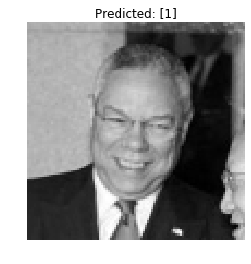

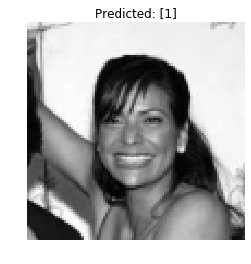

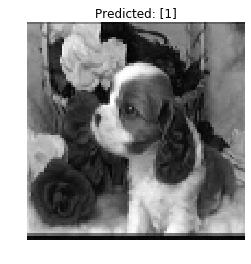

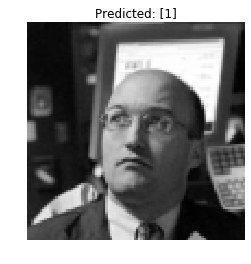

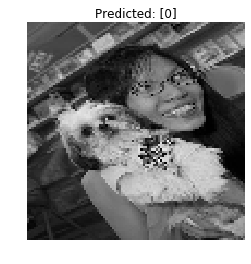

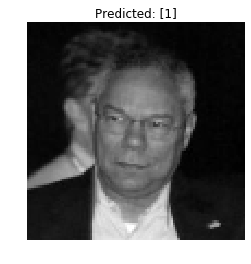

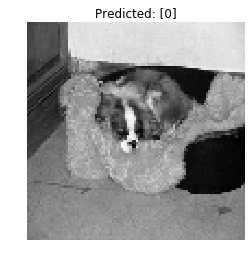

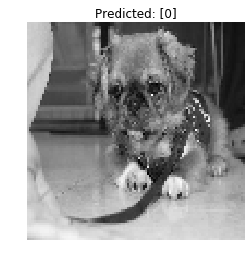

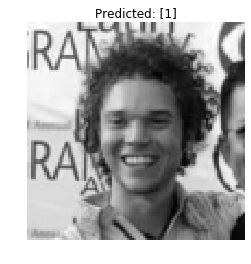

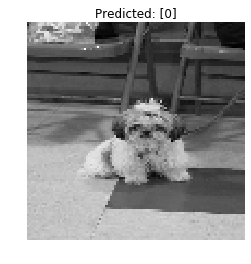

In [0]:
for i in range(10):
    imshow(X_test[i].reshape(100,100), "Predicted: " + str(test_preds[i]), cmap='gray')